In [34]:
import pandas as pd
import numpy as np

import string
import nltk
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import cosine_sim ## This only for testing


In [4]:
df_isp_irc = pd.read_excel('vt_isp_irc.xlsx')
df_isp_task = pd.read_excel('vt_isp_task_mhrs.xlsx')
df_isp_material = pd.read_excel('vt_isp_material_consumption_pricing.xlsx')

df_isq_irc = pd.read_excel('vt_isq_irc.xlsx')
df_isq_task = pd.read_excel('vt_isq_task_mhrs.xlsx')
df_isq_material = pd.read_excel('vt_isq_material_consumption_pricing.xlsx')

df_iux_irc = pd.read_excel('vt_iux_irc.xlsx')
df_iux_task = pd.read_excel('vt_iux_task_mhrs.xlsx')
df_iux_material = pd.read_excel('vt_iux_material_consumption_pricing.xlsx')

In [5]:
df_isp_irc.head(2)                                                                                                            

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000059/0923/1,53,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...,HMV23/000059/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000059/0923/2,34,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...,HMV23/000059/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Fields to consider in 'VT ISP IRC'
- Planned Start Date
- Planned End Date
- Actual Start Date
- Actual End Date
- Est. Man Hrs.
- Actual Man Hrs.
- Insp Req?
- Mech Req?
- Part Required?
- Contract Classification
- Source Task/Discrep. #
- Description
- Corrective Action
- Log Item #

In [6]:
df_isq_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000055/0923/1,57,"DURING ARRIVAL INSPECTION , OBSERVED DENT ON S...",REFER SDIRC HMV23/000055/0923/7 FOR REPAIR DET...,HMV23/000055/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000055/0923/2,53,DURING INSPECTION OBSERVED LH WING SLAT#5 WEAT...,CARRIED OUT INSTALLATION OF LH WING SLAT #5 OU...,HMV23/000055/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


In [7]:
df_iux_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000043/0823/1,33,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1. RH NAV POSITION LIGHT TROUBLESHOOTING CARRI...,HMV23/000043/0823/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000043/0823/2,25,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1.FWD AND AFT WALL MOUNTED CABIN ATTENDENT SEA...,HMV23/000043/0823/2,Close,Closed,AWR23/002577/0823,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Tokenize and embed the descriptions of unexpected observations made.

In [8]:
# Download NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ranjith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ranjith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ranjith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Load spacy en_core_web_sm model
nlp = spacy.load("en_core_web_sm")

In [10]:
def preprocess_text(text: str, preserve_symbols=[]) -> str:
    '''
    This function performs text preprocessing and returns processed text. 
    It will also accept a list of symbols to preserve.
    Input: text
    Output: text
    '''
    # Define symbols to preserve
    preserve_symbols = set(preserve_symbols)
    
    # Remove punctuation, excluding specified symbols
    custom_translation = str.maketrans('', '', ''.join(set(string.punctuation) - preserve_symbols))
    text = text.translate(custom_translation)
    return text


def tokenization(preprocessed_text: str) -> list:
    '''
    This function performs text tokenization and returns a list of tokens.
    Input: text
    Output: list of tokens
    '''
    sentences = sent_tokenize(preprocessed_text)
    preprocessed_tokens = []

    # Tokenization and stopword removal
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.lower() not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        preprocessed_tokens.append(tokens)

    return preprocessed_tokens


def calculate_embeddings(preprocessed_tokens: list) -> list:
    '''
    This function performs text embedding and returns a list of embeddings.
    Input: list of tokens
    Output: list of embeddings
    '''
    # Embedding
    embeddings = []
    for token in preprocessed_tokens:
        sentence = ' '.join(token)
        doc = nlp(sentence)
        sentence_embedding = doc.vector
        embeddings.append(sentence_embedding)

    return embeddings


def main(text: str, preserve_symbols=['#', '/', '-', ':']) -> list:
    '''
    This function performs text preprocessing, tokenization, embedding and returns a list of embeddings.
    Input: text
    Output: list of embeddings
    '''
    preprocessed_text = preprocess_text(text, preserve_symbols)
    preprocessed_tokens = tokenization(preprocessed_text)
    embeddings = calculate_embeddings(preprocessed_tokens)

    return embeddings

In [11]:
df_isp_irc.groupby(by='Source Task/Discrep. #').get_group('AIRCRAFT ARRIVAL INSPECTION')['Description'].tolist()

['1. DURING INSPECTION OBERVED LH WING SLATE #01, TRACK#02 ,#03, #04 UPPER BULB SEAL DAMAGE.SAME TO BE REPLACED.\n\n2. DURING INSPECTION OBSERVED SLAT#02 TRACK #5 PLATE DAMAGE.SAME TO BE REPLACED.',
 'DURING ARRIVAL INSPECTION CHECK FOUND FAILURE MESSAGE IN PFR " NO ADF 1 DATA (INTM) ".',
 'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.',
 'DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION \n1.103VU BATTERY COMPARMENT LAMP FIN: 8LS QTY#1,.\n2. REFUEL/DEFUEL CONTROL PANEL FLOODLIGHT LAMP FIN: 32QU.',
 'DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS DICREPANCIES.\n\n1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL DEGRADED.\n2) RH SIIDE WING SLAT NO#5 OUT BOARD WEATHER SEAL ERODED. SAME TO BE REPLACED.',
 'DURING INSPECTION FOUND FOLLOWING

### ISP

In [12]:
grouped_df_Description = df_isp_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_isp_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_isp_irc['description_correction'] = df_isp_irc['Description'] +' '+df_isp_irc['Corrective Action']
grouped_df_description_correction = df_isp_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [13]:
grouped_df_Description

Source Task/Discrep. #         
215222-01-1 (LH)             9     [[-0.404925, -0.054837763, 0.015778754, -0.463...
                             12    [[-0.6733928, -0.17803305, 0.13669693, 0.15644...
252100-01-1                  16    [[-0.5620832, -0.006267702, -0.22605507, 0.423...
384241-01-1                  11    [[-0.22561774, -0.09848608, 0.3168459, 0.54762...
531900-03-1                  10    [[-0.5104654, -0.32680652, 0.36707053, 0.03859...
AIRCRAFT ARRIVAL INSPECTION  0     [[-0.64320844, -0.07742605, -0.32219216, 0.279...
                             1     [[-0.34986612, -0.25470546, -0.20057899, 0.184...
                             2     [[-0.25188813, -0.16425797, -0.39383945, 0.249...
                             3     [[-0.55938756, -0.23792706, -0.15409206, 0.058...
                             4     [[-0.44807178, -0.30468988, -0.2933644, 0.2563...
                             5     [[-0.3829494, -0.45530254, 0.28193352, 0.19516...
                             6   

In [14]:
df_isp_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_isp_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_isp_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [15]:
df_isp_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...,"[-0.404925, -0.054837763, 0.015778754, -0.4631...","[-0.7883508, -0.48455766, 0.053018823, 0.28613...","[-0.64392567, -0.32557, 0.09585165, 0.09748258..."
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...,"[-0.6733928, -0.17803305, 0.13669693, 0.156445...","[-0.81899613, -0.536668, 0.20998687, 0.4754251...","[-0.7522026, -0.45083523, 0.18606621, 0.415954..."
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...,STATIC DISCHARGERS REPLACED AT FOLLOWING LOCAT...,"[-0.5620832, -0.006267702, -0.22605507, 0.4239...","[-0.6431541, -0.4975288, 0.35840395, 0.6532554...","[-0.6112287, -0.3528504, 0.17231278, 0.5829198..."
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...,1. CARRIED OUT REPLACEMENT OF SERVICE LIGHT LA...,"[-0.22561774, -0.09848608, 0.3168459, 0.547622...","[-0.7275441, -0.58689135, 0.39343697, 0.385342...","[-0.57389027, -0.44901672, 0.30712327, 0.43411..."
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS...","1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SE...","[-0.5104654, -0.32680652, 0.36707053, 0.038590...","[-0.7171926, -0.6179478, 0.64386773, 0.5765455...","[-0.63411736, -0.52430564, 0.5837834, 0.416250..."


### ISQ

In [16]:
grouped_df_Description = df_isq_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_isq_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_isq_irc['description_correction'] = df_isq_irc['Description'] +' '+df_isq_irc['Corrective Action']
grouped_df_description_correction = df_isq_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [17]:
df_isq_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_isq_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_isq_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [18]:
df_isq_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000055/0923/1,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED DENT ON S...",REFER SDIRC HMV23/000055/0923/7 FOR REPAIR DET...,"[-0.6202869, -0.25039947, 0.34919968, -0.12908...","[-0.7295349, -0.713442, 0.51912445, 0.39860415...","[-0.6796822, -0.59584635, 0.43895823, 0.333605..."
1,HMV23/000055/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING INSPECTION OBSERVED LH WING SLAT#5 WEAT...,CARRIED OUT INSTALLATION OF LH WING SLAT #5 OU...,"[-0.36058718, -0.18217793, -0.13120583, -0.432...","[-0.7883508, -0.48455766, 0.053018823, 0.28613...","[-0.62857825, -0.36964813, 0.044973053, 0.1079..."
2,HMV23/000055/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING WARN...,NO FAILURE MSG RELATED TO WARNING MSG FOUND IN...,"[-0.55612564, -0.0055004945, -0.20293741, 0.42...","[-0.6374442, -0.50481325, 0.3339568, 0.6283129...","[-0.60634667, -0.36188558, 0.16684118, 0.56770..."
3,HMV23/000055/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING FAIL...,T/S CARRIED OUT AS PER TSM 34-53-00-810-801-A ...,"[-0.5449455, -0.31652254, 0.52052444, 0.425085...","[-0.61867714, -0.47241265, 0.5103181, 0.364327...","[-0.58505034, -0.40784353, 0.5063603, 0.375258..."
4,HMV23/000055/0923/5,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING FAIL...,CARRIED OUT TROUBLESHOOTING IAW TSM 38-31-00-8...,"[-0.5387709, -0.43726465, 0.33631384, 0.352513...","[-0.7275441, -0.58689135, 0.39343697, 0.385342...","[-0.6109697, -0.5399237, 0.446379, 0.39137608,..."


### IUX

In [19]:
grouped_df_Description = df_iux_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_iux_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_iux_irc['description_correction'] = df_iux_irc['Description'] +' '+df_iux_irc['Corrective Action']
grouped_df_description_correction = df_iux_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [20]:
df_iux_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_iux_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_iux_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [21]:
df_iux_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000043/0823/1,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1. RH NAV POSITION LIGHT TROUBLESHOOTING CARRI...,"[-0.18441391, -0.4426329, -0.51357967, 0.39346...","[-0.7106022, -0.6184002, 0.35787284, 0.6952081...","[-0.5425435, -0.533102, 0.104508825, 0.5931678..."
1,HMV23/000043/0823/2,AWR23/002577/0823,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1.FWD AND AFT WALL MOUNTED CABIN ATTENDENT SEA...,"[-0.34896496, -0.2882238, -0.25253052, 0.41508...","[-0.6725227, -0.5701257, 0.34549743, 0.5608027...","[-0.620729, -0.5208698, 0.24195488, 0.5342858,..."
2,HMV23/000043/0823/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED DELAMINATIO...,"1)REMOVED FWD CARGO FLOOR PANEL 131AF,131EF,13...","[-0.5505663, -0.14447877, -0.3049737, 0.247405...","[-0.60518837, -0.497075, 0.29910305, 0.4456184...","[-0.5878989, -0.3819491, 0.13637681, 0.3801480..."
3,HMV23/000043/0823/4,WEAR LIMITS- BONDING LEADS,"DURING PHYSICAL INSPECTION OF BONDING LEADS, O...",BONDING JUMPERS AT FOLLOWING LOCATIONS REPLACE...,"[-0.5689658, -0.14116651, -0.26039046, 0.12483...","[-0.6041223, -0.367361, 0.22923344, 0.37777913...","[-0.5932065, -0.27771977, 0.072612755, 0.28357..."
4,HMV23/000043/0823/5,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED DELAMINATIO...,"1)REMOVED AFT CARGO FLOOR PANELS 151SG,151DF,1...","[-0.34185055, -0.53021324, 0.42304727, 0.25789...","[-0.51604086, -0.20242906, -0.49226576, 0.2427...","[-0.38736144, -0.41291052, 0.11088909, 0.26603..."


### Similarity matrix for Description column

In [75]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['description_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['description_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['description_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [81]:
display(isp_vec.head(2))
display(isq_vec.head(2))
display(iux_vec.head(2))
display(iux_vec.shape)

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000059/0923/12,HMV23/000059/0923/13,HMV23/000059/0923/14,HMV23/000059/0923/15,HMV23/000059/0923/16,HMV23/000059/0923/17,HMV23/000059/0923/18,HMV23/000059/0923/19,HMV23/000059/0923/20,HMV23/000059/0923/21
0,-0.404925,-0.673393,-0.562083,-0.225618,-0.510465,-0.643208,-0.349866,-0.251888,-0.559388,-0.448072,...,-0.411577,-0.62479,-0.553922,-0.529377,-0.663301,-0.942752,-0.456783,0.061582,-0.39794,-0.327086
1,-0.054838,-0.178033,-0.006268,-0.098486,-0.326807,-0.077426,-0.254705,-0.164258,-0.237927,-0.30469,...,-0.399411,-0.134206,-0.121132,0.044312,-0.451737,-0.445293,-0.193505,-0.391149,-0.460531,-0.237111


,HMV23/000055/0923/1,HMV23/000055/0923/2,HMV23/000055/0923/3,HMV23/000055/0923/4,HMV23/000055/0923/5,HMV23/000055/0923/6,HMV23/000055/0923/7,HMV23/000055/0923/8,HMV23/000055/0923/9,HMV23/000055/0923/10,...,HMV23/000055/0923/17,HMV23/000055/0923/18,HMV23/000055/0923/19,HMV23/000055/0923/20,HMV23/000055/0923/21,HMV23/000055/0923/22,HMV23/000055/0923/23,HMV23/000055/0923/24,HMV23/000055/0923/25,HMV23/000055/0923/26
0,-0.620287,-0.360587,-0.556126,-0.544945,-0.538771,-0.322631,-0.440061,-0.417339,-0.357636,-0.661139,...,-0.553922,-0.092055,-0.165695,-0.524881,-0.495324,-0.393066,-0.415911,-0.453369,-0.402833,-0.346185
1,-0.250399,-0.182178,-0.0055,-0.316523,-0.437265,-0.125204,-0.350991,-0.247899,-0.00167,-0.273701,...,-0.121132,-0.34217,-0.158121,-0.14104,-0.137909,-0.288855,-0.433487,-0.302986,-0.45472,-0.289327


,HMV23/000043/0823/1,HMV23/000043/0823/2,HMV23/000043/0823/3,HMV23/000043/0823/4,HMV23/000043/0823/5,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.184414,-0.348965,-0.550566,-0.568966,-0.341851,-0.304819,-0.398453,-0.430696,-0.469149,-0.504276,-0.354912,-0.419394,-0.102901,-0.746799,-0.41171
1,-0.442633,-0.288224,-0.144479,-0.141167,-0.530213,-0.209131,-0.390532,-0.289989,-0.660829,-0.648111,-0.445601,-0.748484,-0.704368,-0.61724,-0.064449


(96, 15)

In [82]:
df_description = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_description

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.404925,-0.673393,-0.562083,-0.225618,-0.510465,-0.643208,-0.349866,-0.251888,-0.559388,-0.448072,...,-0.304819,-0.398453,-0.430696,-0.469149,-0.504276,-0.354912,-0.419394,-0.102901,-0.746799,-0.41171
1,-0.054838,-0.178033,-0.006268,-0.098486,-0.326807,-0.077426,-0.254705,-0.164258,-0.237927,-0.30469,...,-0.209131,-0.390532,-0.289989,-0.660829,-0.648111,-0.445601,-0.748484,-0.704368,-0.61724,-0.064449
2,0.015779,0.136697,-0.226055,0.316846,0.367071,-0.322192,-0.200579,-0.393839,-0.154092,-0.293364,...,-0.36774,-0.123348,-0.040818,0.343267,0.316379,-0.208569,0.525122,0.427706,0.181267,-0.232419
3,-0.463113,0.156445,0.423995,0.547623,0.03859,0.27953,0.184987,0.249067,0.058867,0.256309,...,0.155044,0.433066,0.230894,0.26319,0.336225,0.30934,0.280647,0.184328,0.283139,0.428349
4,0.053595,0.494805,0.419376,0.379678,0.469521,0.364759,-0.160577,0.176674,0.063714,0.156452,...,-0.02275,0.451077,0.022069,0.670724,0.848522,-0.049148,0.532573,0.279764,0.955684,0.317332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.08005,0.003736,-0.329235,0.285456,0.355029,-0.658544,-0.139005,-0.294024,0.042496,-0.331385,...,-0.343742,-0.170874,-0.095021,0.100613,0.088961,-0.335883,0.431294,0.511491,0.048983,-0.502632
92,1.261004,1.232471,1.303316,1.445711,0.858768,0.878122,1.450438,1.367947,1.216033,1.362913,...,1.156885,1.650976,1.434114,0.768876,0.616883,1.719709,0.956131,1.31147,0.409709,1.203405
93,0.266378,0.199087,0.339024,-0.073678,0.120008,0.60144,0.345303,0.353478,0.195113,0.381631,...,0.440833,0.053593,0.263674,0.052562,0.065593,0.072269,0.010873,0.106401,0.220411,0.289764
94,0.512838,-0.246142,0.208215,0.285036,-0.18313,0.113458,0.317521,-0.048825,-0.100188,0.200652,...,0.031281,0.076185,-0.152962,-0.138683,-0.264777,-0.22271,-0.202091,-0.411092,-0.028395,-0.235252


In [83]:
cos_sim_description_mat = cosine_similarity(df_description.T)
cosine_sim_description_df = pd.DataFrame(cos_sim_description_mat, index=df_description.columns, columns=df_description.columns)

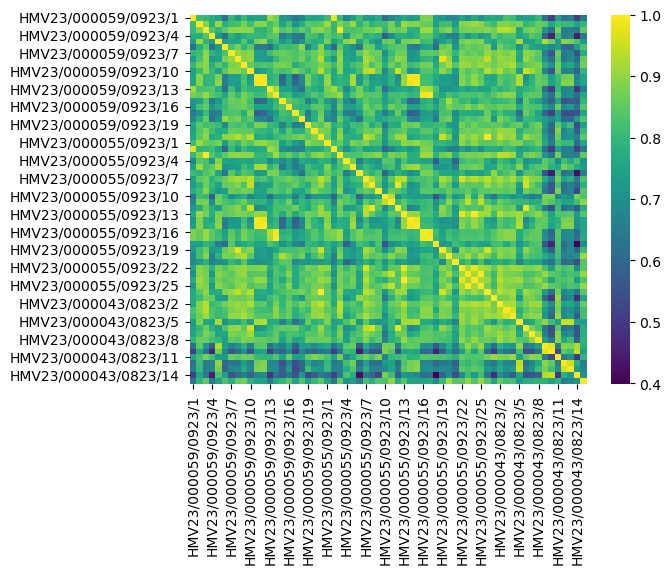

In [85]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_description_df, cmap='viridis')
plt.show()

In [89]:
cosine_sim_description_df.to_csv('./similarityMatrixFiles/cos_sim_description.csv', index=True)

### Similarity Matrix for "Corrective Measure"

In [90]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['corrective_action_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['corrective_action_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['corrective_action_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [91]:
df_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_correction

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.788351,-0.818996,-0.643154,-0.727544,-0.717193,-0.543841,-0.808907,-0.493546,-0.712355,-0.491019,...,-0.431795,-0.679378,-0.887238,-0.665196,-0.604308,-0.727951,-0.509544,-0.581944,-0.65183,-0.506009
1,-0.484558,-0.536668,-0.497529,-0.586891,-0.617948,-0.422132,-0.560408,-0.439865,-0.491665,-0.536208,...,-0.530002,-0.430323,0.045907,-0.70564,-0.604927,-0.61554,-0.76545,-0.714384,-0.542229,-0.273363
2,0.053019,0.209987,0.358404,0.393437,0.643868,0.082585,0.204325,0.124915,0.23843,0.187807,...,0.18318,0.300454,-0.071734,0.296292,0.307653,0.48842,0.855134,0.519969,0.187692,0.066768
3,0.286135,0.475425,0.653255,0.385343,0.576545,0.443941,0.621222,0.529121,0.527615,0.386857,...,0.505737,0.593985,0.329493,0.350383,0.358657,0.23521,0.32597,0.189935,0.387117,0.498831
4,0.869403,1.173708,1.036932,0.981595,1.455833,0.732516,1.245592,0.905178,1.014995,0.760292,...,0.706712,1.061776,-0.06446,0.835634,1.139122,0.832327,0.86294,0.838935,0.773803,0.786894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.197221,-0.129722,0.022195,0.23597,0.268289,-0.093157,-0.090512,0.058412,0.008064,-0.012132,...,0.0371,0.128548,-0.370823,0.135631,0.105496,0.286697,0.5095,0.199701,-0.110778,-0.205119
92,0.695078,0.662038,0.559556,0.765284,0.022875,0.664131,0.291611,0.640278,0.573255,0.699172,...,0.689714,0.530089,1.729075,0.495893,0.505196,0.688253,0.456129,0.519634,0.808327,0.76451
93,0.243106,0.220029,0.11637,-0.048681,0.058354,0.358017,0.155041,0.244534,0.120548,0.238494,...,0.23757,0.197783,0.316275,0.05522,0.196231,0.010106,0.028203,0.10551,0.212605,0.158654
94,0.139806,-0.105967,-0.193628,-0.084573,-0.396006,-0.217026,-0.236569,-0.235489,-0.298602,-0.215897,...,-0.15408,-0.338151,0.273594,-0.182747,-0.269365,-0.086931,-0.34445,-0.214235,-0.15799,-0.316065


In [94]:
cos_sim_correction_mat = cosine_similarity(df_correction.T)
cosine_sim_correction_df = pd.DataFrame(cos_sim_correction_mat, index=df_correction.columns, columns=df_correction.columns)

In [95]:
cosine_sim_correction_df.to_csv('./similarityMatrixFiles/cos_sim_correction.csv', index=True)

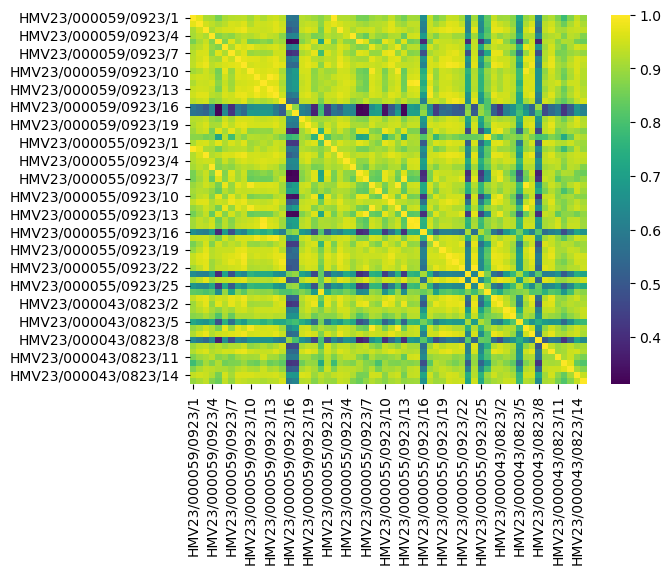

In [96]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_correction_df, cmap='viridis')
plt.show()

### Similarity Matrix for "Description + Corrective Measure"

In [98]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['description_correction_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['description_correction_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['description_correction_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [99]:
df_desc_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_desc_correction

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.643926,-0.752203,-0.611229,-0.57389,-0.634117,-0.569013,-0.729915,-0.404679,-0.677853,-0.475366,...,-0.380909,-0.604962,-0.464659,-0.534851,-0.49902,-0.65377,-0.428844,-0.426705,-0.693982,-0.468541
1,-0.32557,-0.450835,-0.35285,-0.449017,-0.524306,-0.324879,-0.509708,-0.354334,-0.451679,-0.46561,...,-0.426376,-0.410327,-0.272066,-0.669428,-0.614578,-0.58492,-0.764068,-0.704934,-0.570615,-0.181341
2,0.095852,0.186066,0.172313,0.307123,0.583783,-0.044744,0.142121,-0.033192,0.180057,0.038784,...,0.026056,0.217833,-0.017323,0.34385,0.313184,0.368226,0.721066,0.482311,0.182,-0.06073
3,0.097483,0.415954,0.58292,0.434112,0.416251,0.388794,0.562792,0.446653,0.444995,0.337658,...,0.382775,0.550063,0.253669,0.291312,0.351134,0.249784,0.309763,0.181917,0.354997,0.470441
4,0.5861,0.968912,0.858651,0.847273,1.130795,0.625074,1.037781,0.687192,0.849065,0.572343,...,0.504369,0.939391,-0.042171,0.770477,0.975742,0.683121,0.756714,0.662789,0.863316,0.583965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.16048,-0.106343,-0.094956,0.312779,0.285461,-0.2539,-0.1086,-0.045894,0.015618,-0.107495,...,-0.030471,0.07945,-0.162719,0.09579,0.091272,0.181632,0.520398,0.29305,-0.014085,-0.332527
92,0.957524,0.814231,0.774166,0.957806,0.278433,0.733547,0.441897,0.866918,0.690486,0.904911,...,0.827682,0.729146,1.493662,0.640807,0.575861,0.860703,0.65915,0.767085,0.606091,0.952293
93,0.187321,0.206536,0.189115,-0.082536,0.087709,0.43191,0.180741,0.274804,0.13223,0.285986,...,0.298575,0.179166,0.27402,0.059061,0.12527,0.020791,0.010128,0.103562,0.20444,0.20986
94,0.266146,-0.137549,-0.073488,0.002201,-0.309925,-0.10968,-0.145327,-0.172487,-0.261782,-0.086249,...,-0.124454,-0.254232,-0.048507,-0.151417,-0.28997,-0.113092,-0.288392,-0.277445,-0.08478,-0.272948


In [101]:
cos_sim_desc_correction_mat = cosine_similarity(df_desc_correction.T)
cosine_sim_desc_correction_df = pd.DataFrame(cos_sim_desc_correction_mat, index=df_desc_correction.columns, columns=df_desc_correction.columns)

In [102]:
cosine_sim_desc_correction_df.to_csv('./similarityMatrixFiles/cos_sim_desc_correction.csv', index=True)

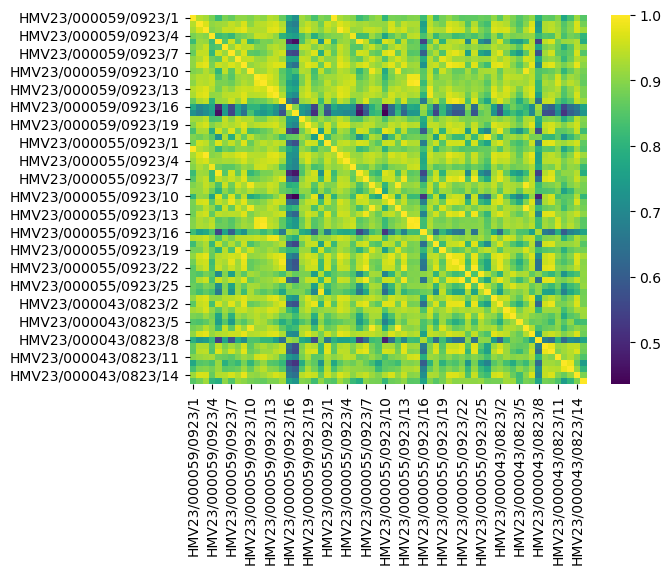

In [103]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_desc_correction_df, cmap='viridis')
plt.show()